# Summer analysis 2023: ndvi+ndmi+marginalization

This notebook finds zones that may recieve irrigation within urban spaces by relating (res 10) vegetation (ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds) and moisture.
Resulting zones which have vegetation and little variations in moisture compared to the rest of the urban area may recieve irrigation, be part of a natural waterway.

Furthermore, the analysis includes a relation of analyzed data with marginalization. (res8)

#### First analysis: NDVI - NDMI - Marginalization correlation in boxplot (Res 8)

1. Download NDVI and NDMI res 8
2. Create vegetation categories for NDVI
3. Filter NDVI for places with vegetation
4. Merge NDVI and NDMI
5. For those hex, download marginalization data
6. Create marginalization categories
7. Data analysis in boxplot

#### Second analysis: NDVI - NDMI visual correlation (Res 10)

1. Download NDVI and NDMI res 10
2. Create vegetation categories for NDVI
3. Filter NDVI for places with vegetation
4. Merge NDVI and NDMI
5. Data analysis in visual correlation (map)

## Notes: NDVI and NDMI content and availability

NDVI --> hex_id, res, ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend, city
* res: 8,9,10,11
* city: Aguascalientes, Cancun, Chihuahua, Chilpancingo, Coatzacoalcos, Colima, Cuernavaca, Culiacan, Durango, Ensenada, Guadalajara, Guanajuato, Juarez, La Paz, Leon, Matamoros, Mazatlan, Merida, Minatitlan, Monclova, Monterrey, Moroleon, Nogales, Nuevo Laredo, Oaxaca, Ocotlan, Pachuca, Parral, Piedad, Piedras Negras, Queretaro, Tijuana, Tuxtla, ZMVM.

NDMI --> hex_id, res, ndmi_mean, ndmi_std, ndmi_median, ndmi_max, ndmi_min, ndmi_diff, ndmi_tend, city
* res: 8,9,10,11
* city: Chihuahua, Guadalajara, Leon, Merida, Monterrey, Puebla (¡Puebla not in NDVI!), Queretaro, Tijuana, Tuxtla, ZMVM.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
city = 'Guadalajara'

In [3]:
csv_dataset = False

# First analysis: NDVI - NDMI - Marginalization correlation (Res 8)

## Data download

Data download - NDVI

In [4]:
# Downloading NDVI res 8 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 8

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res8 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res8.shape)
ndvi_res8.head(2)

(1187, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,88498c8649fffff,"POLYGON ((-103.32357 20.76827, -103.32865 20.7...",8,0.244760,0.100867,0.247440,0.368982,0.115646,0.253336,-0.002247,Guadalajara
1,88498c864bfffff,"POLYGON ((-103.32919 20.77561, -103.33427 20.7...",8,0.269992,0.122279,0.255744,0.431332,0.113069,0.318263,-0.001899,Guadalajara


Data download - NDMI

In [5]:
# Downloading NDMI res 8 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 8

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res8 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res8.shape)
ndmi_res8.head(2)

(1187, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,88498c8649fffff,"POLYGON ((-103.32357 20.76827, -103.32865 20.7...",8,0.002498,0.061516,-0.002444,0.097146,-0.075964,0.173110,-0.000222,Guadalajara
1,88498c864bfffff,"POLYGON ((-103.32919 20.77561, -103.33427 20.7...",8,0.014530,0.079156,0.005282,0.133249,-0.091163,0.224412,-0.000291,Guadalajara


## Data treatment

### Data treatment - NDVI + NDMI

Data treatment - Creating vegetation categories

In [6]:
# NDVI res 8 processing
# Creating vegetation categories
ndvi_res8['ndvi_median_rango'] = np.nan
ndvi_res8.loc[ndvi_res8.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_res8.loc[(ndvi_res8.ndvi_median>=0.4 )&
             (ndvi_res8.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_res8.loc[(ndvi_res8.ndvi_median>=0.2)&
             (ndvi_res8.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_res8.loc[(ndvi_res8.ndvi_median>=0.1)&
             (ndvi_res8.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_res8.loc[(ndvi_res8.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_res8['ndvi_median_rango'] = pd.Categorical(ndvi_res8['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_res8.shape)
ndvi_res8.head(2)

(1187, 12)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,ndvi_median_rango
0,88498c8649fffff,"POLYGON ((-103.32357 20.76827, -103.32865 20.7...",8,0.244760,0.100867,0.247440,0.368982,0.115646,0.253336,-0.002247,Guadalajara,Mínima densidad vegetal
1,88498c864bfffff,"POLYGON ((-103.32919 20.77561, -103.33427 20.7...",8,0.269992,0.122279,0.255744,0.431332,0.113069,0.318263,-0.001899,Guadalajara,Mínima densidad vegetal


Data treatment - NDVI filtering for places with vegetation

In [7]:
#Keeping High-moderate-minimal vegetation density
ndvi_withveg_res8 = ndvi_res8.loc[(ndvi_res8.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_res8.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_res8.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(ndvi_withveg_res8.shape)
ndvi_withveg_res8.head(2)

(774, 12)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,ndvi_median_rango
0,88498c8649fffff,"POLYGON ((-103.32357 20.76827, -103.32865 20.7...",8,0.244760,0.100867,0.247440,0.368982,0.115646,0.253336,-0.002247,Guadalajara,Mínima densidad vegetal
1,88498c864bfffff,"POLYGON ((-103.32919 20.77561, -103.33427 20.7...",8,0.269992,0.122279,0.255744,0.431332,0.113069,0.318263,-0.001899,Guadalajara,Mínima densidad vegetal


Data treatment - Merging NDVI and NDMI

In [8]:
ndmi_res8_clean = ndmi_res8.drop(columns=['geometry','res','city'])
ndvi_ndmi_res8 = ndvi_withveg_res8.merge(ndmi_res8_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_res8.shape)
ndvi_ndmi_res8.head(2)

(774, 19)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,ndvi_median_rango,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,88498c8649fffff,"POLYGON ((-103.32357 20.76827, -103.32865 20.7...",8,0.244760,0.100867,0.247440,0.368982,0.115646,0.253336,-0.002247,Guadalajara,Mínima densidad vegetal,0.002498,0.061516,-0.002444,0.097146,-0.075964,0.173110,-0.000222
1,88498c864bfffff,"POLYGON ((-103.32919 20.77561, -103.33427 20.7...",8,0.269992,0.122279,0.255744,0.431332,0.113069,0.318263,-0.001899,Guadalajara,Mínima densidad vegetal,0.014530,0.079156,0.005282,0.133249,-0.091163,0.224412,-0.000291


### Data treatment - Download marginalization data from merged ndvi-ndmi geometries and merge

Marginalization data download

In [9]:
# Finds hex_id codes where vegetation is present and there is ndmi data
hex_ids = str(tuple(list(ndvi_ndmi_res8["hex_id"].unique())))

# Location of hexagons with marginalization data
marg_schema = 'censo'
marg_folder = 'hex_bins_marg_2020'

query = f"SELECT * FROM {marg_schema}.{marg_folder} WHERE \"hex_id_8\" IN {hex_ids}"
marg_res8 = aup.gdf_from_query(query, geometry_col='geometry')

print(marg_res8.shape)
marg_res8.head(2)

(750, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,89.333336,1.282051,7.092198,7.960199,0.0000,0.000000,0.621891,0.000000,1.492537,15.049751,0.373134,8.333333,122.339516,0.955670


Marginalization data treatment

In [10]:
#Creating marginalization categories
marg_res8['Grado_Marg'] = np.nan
marg_res8.loc[marg_res8.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
marg_res8.loc[(marg_res8.imn_2020>=0.946436 )&
             (marg_res8.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
marg_res8.loc[(marg_res8.imn_2020>=0.926536)&
             (marg_res8.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
marg_res8.loc[(marg_res8.imn_2020>=0.8999)&
             (marg_res8.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
marg_res8.loc[(marg_res8.imn_2020<0.8999), 'Grado_Marg'] = 'Muy Alto'

#Ordening data
categories = ['Muy Alto', 'Alto', 'Medio', 'Bajo', 'Muy bajo']
marg_res8['Grado_Marg'] = pd.Categorical(marg_res8['Grado_Marg'], categories=categories, ordered=True)

#Reviewing process
print(marg_res8.shape)
marg_res8.head(2)

(750, 18)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020,Grado_Marg
0,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8849abc9ebfffff,14002,273.168550,0.474944,2.828432,1.787101,0.1098,0.008903,0.115735,0.029676,0.697379,4.282201,0.593514,2.756871,120.556725,0.941744,Medio
1,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8849abc9e3fffff,14002,89.333336,1.282051,7.092198,7.960199,0.0000,0.000000,0.621891,0.000000,1.492537,15.049751,0.373134,8.333333,122.339516,0.955670,Bajo


Final merge

In [11]:
columns_tokeep = ['hex_id_8','pobtot','Grado_Marg']
marg_res8_clean = marg_res8[columns_tokeep]
ndvi_ndmi_marg = ndvi_ndmi_res8.merge(marg_res8_clean, left_on='hex_id', right_on='hex_id_8')
ndvi_ndmi_marg = ndvi_ndmi_marg.drop(columns=['hex_id_8'])

#Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(750, 21)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndvi_median_rango,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,pobtot,Grado_Marg
0,88498c8649fffff,"POLYGON ((-103.32357 20.76827, -103.32865 20.7...",8,0.244760,0.100867,0.247440,0.368982,0.115646,0.253336,-0.002247,...,Mínima densidad vegetal,0.002498,0.061516,-0.002444,0.097146,-0.075964,0.173110,-0.000222,4877.1390,Alto
1,88498c864bfffff,"POLYGON ((-103.32919 20.77561, -103.33427 20.7...",8,0.269992,0.122279,0.255744,0.431332,0.113069,0.318263,-0.001899,...,Mínima densidad vegetal,0.014530,0.079156,0.005282,0.133249,-0.091163,0.224412,-0.000291,877.6089,Alto


### Export ndvi+ndmi+marg csv

## if csv_dataset:
    csv_raster_dataset = ndvi_ndmi_marg.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../data/external/ndvi_ndmi_marg_{}".format(city.lower()))

## Data analysis

### Data analysis - Boxplot

In [13]:
ndvi_ndmi_marg = ndvi_ndmi_marg.sort_values('Grado_Marg')
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.Grado_Marg.isna()]

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndvi_median_rango,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,pobtot,Grado_Marg


      index  Grado_Marg
4  Muy Alto          29
2      Alto         155
0     Medio         225
3      Bajo         155
1  Muy bajo         186


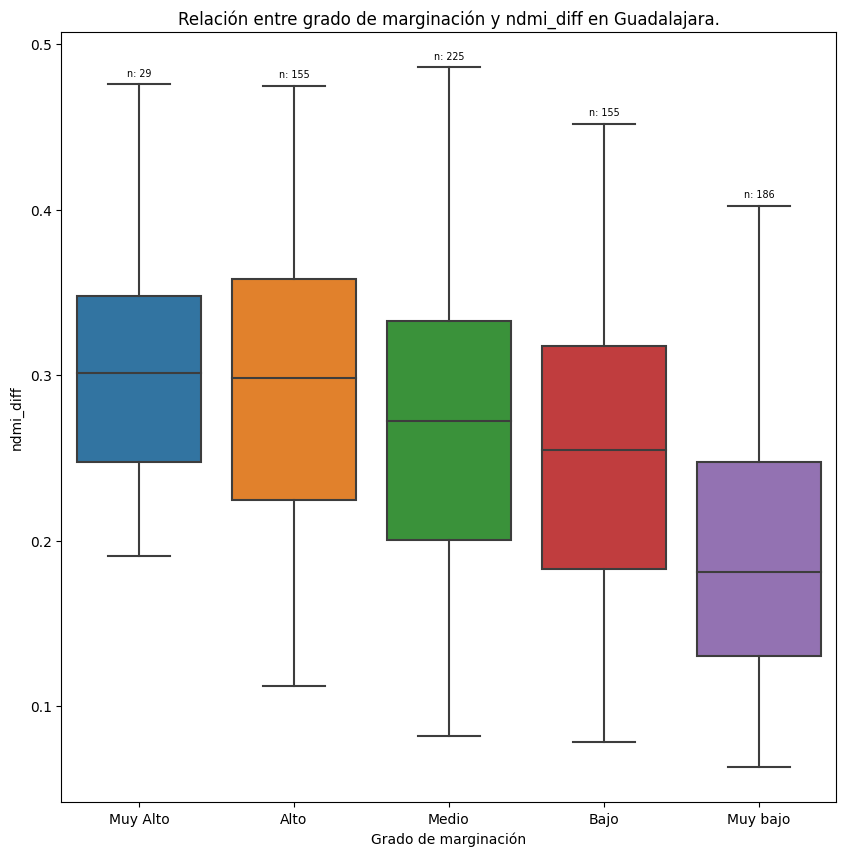

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

sns.boxplot(x=np.array(ndvi_ndmi_marg.Grado_Marg) , y=np.array(ndvi_ndmi_marg.ndmi_diff), ax=ax)

plt.title('Relación entre grado de marginación y ndmi_diff en {}.'.format(city))
plt.xlabel('Grado de marginación')
plt.ylabel('ndmi_diff')

# ------------------------------------------- Add number of hex per marginalization group -------------------------------------------

#Calculate median of each Marginalization group to position number of observations
maxs = ndvi_ndmi_marg.groupby(['Grado_Marg'])['ndmi_diff'].max()
num_maxs = maxs.values
#Drop NaNs
num_maxs = num_maxs[~np.isnan(num_maxs)]

# Calculate number of observations per group
obs = ndvi_ndmi_marg['Grado_Marg'].value_counts()
obs = obs.reset_index()
obs = obs.sort_values('index')
print(obs)
#Drop Ceros by turning them to nans
obs = obs['Grado_Marg'].apply(lambda x: np.nan if x==0 else x)
obs = obs[~np.isnan(obs)]

num_obs = obs.values
num_obs = [str(x) for x in num_obs.tolist()]
num_obs = ["n: " + i for i in num_obs]

# Add it to the plot
pos = range(len(num_obs))
for tick,label in zip(pos,ax.get_xticklabels()):
    #ax.text(x,y,text)
    ax.text(pos[tick],
            num_maxs[tick] + 0.005,
            num_obs[tick],
            horizontalalignment='center',
            size='x-small',
            color='black')
# ------------------------------------------- ------------------------------------------- -------------------------------------------

#Para plotear figuras quitar # 
plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_marg_boxplot_{}.svg".format(city.lower(),city.lower()))

# Second analysis: NDVI - NDMI correlation (Res 10)

## Data download

Data download - NDVI

In [15]:
# Downloading NDVI res 10 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res10.shape)
ndvi_res10.head(2)

(58163, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a49ab4b2717fff,"POLYGON ((-103.38873 20.74741, -103.38808 20.7...",10,0.299616,0.106006,0.296429,0.427786,0.154227,0.273559,-0.002171,Guadalajara
1,8a49ab4b266ffff,"POLYGON ((-103.39412 20.75251, -103.39348 20.7...",10,0.149564,0.030770,0.158817,0.169151,0.107430,0.061721,-0.000915,Guadalajara


Data download - NDMI

In [16]:
# Downloading NDMI res 10 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res10.shape)
ndmi_res10.head(2)

(58163, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a498c865b9ffff,"POLYGON ((-103.35097 20.78477, -103.35032 20.7...",10,0.064716,0.121298,0.053016,0.229568,-0.106614,0.336182,-0.000149,Guadalajara
1,8a49ab59a16ffff,"POLYGON ((-103.42643 20.68305, -103.42579 20.6...",10,0.051527,0.051866,0.056517,0.137001,-0.026647,0.163648,-0.000598,Guadalajara


## Data treatment

Data treatment - Creating vegetation categories

In [17]:
# NDVI res 10 processing
# Creating vegetation categories
ndvi_res10['ndvi_median_rango'] = np.nan
ndvi_res10.loc[ndvi_res10.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_res10.loc[(ndvi_res10.ndvi_median>=0.4 )&
             (ndvi_res10.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_res10.loc[(ndvi_res10.ndvi_median>=0.2)&
             (ndvi_res10.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_res10.loc[(ndvi_res10.ndvi_median>=0.1)&
             (ndvi_res10.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_res10.loc[(ndvi_res10.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_res10['ndvi_median_rango'] = pd.Categorical(ndvi_res10['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_res10.shape)
ndvi_res10.head(2)

(58163, 12)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,ndvi_median_rango
0,8a49ab4b2717fff,"POLYGON ((-103.38873 20.74741, -103.38808 20.7...",10,0.299616,0.106006,0.296429,0.427786,0.154227,0.273559,-0.002171,Guadalajara,Mínima densidad vegetal
1,8a49ab4b266ffff,"POLYGON ((-103.39412 20.75251, -103.39348 20.7...",10,0.149564,0.030770,0.158817,0.169151,0.107430,0.061721,-0.000915,Guadalajara,Suelo


Data treatment - NDVI filtering for places with vegetation

In [18]:
#Keeping High-moderate-minimal vegetation density
ndvi_withveg_res10 = ndvi_res10.loc[(ndvi_res10.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_res10.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_res10.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(ndvi_withveg_res10.shape)
ndvi_withveg_res10.head(2)

(34361, 12)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,ndvi_median_rango
0,8a49ab4b2717fff,"POLYGON ((-103.38873 20.74741, -103.38808 20.7...",10,0.299616,0.106006,0.296429,0.427786,0.154227,0.273559,-0.002171,Guadalajara,Mínima densidad vegetal
2,8a49ab4b265ffff,"POLYGON ((-103.39218 20.75382, -103.39153 20.7...",10,0.240518,0.068065,0.256728,0.308129,0.146020,0.162110,-0.000966,Guadalajara,Mínima densidad vegetal


Data treatment - Merging NDVI and NDMI

In [19]:
ndmi_res10_clean = ndmi_res10.drop(columns=['geometry','res','city'])
ndvi_ndmi_res10 = ndvi_withveg_res10.merge(ndmi_res10_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_res10.shape)
ndvi_ndmi_res10.head(2)

(34361, 19)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,ndvi_median_rango,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,8a49ab4b2717fff,"POLYGON ((-103.38873 20.74741, -103.38808 20.7...",10,0.299616,0.106006,0.296429,0.427786,0.154227,0.273559,-0.002171,Guadalajara,Mínima densidad vegetal,0.040085,0.073231,0.034313,0.161902,-0.05802,0.219922,0.000142
1,8a49ab4b265ffff,"POLYGON ((-103.39218 20.75382, -103.39153 20.7...",10,0.240518,0.068065,0.256728,0.308129,0.146020,0.162110,-0.000966,Guadalajara,Mínima densidad vegetal,0.046106,0.043520,0.036958,0.123636,0.00750,0.116136,0.000058


## Data analysis - Visual correlation analysis

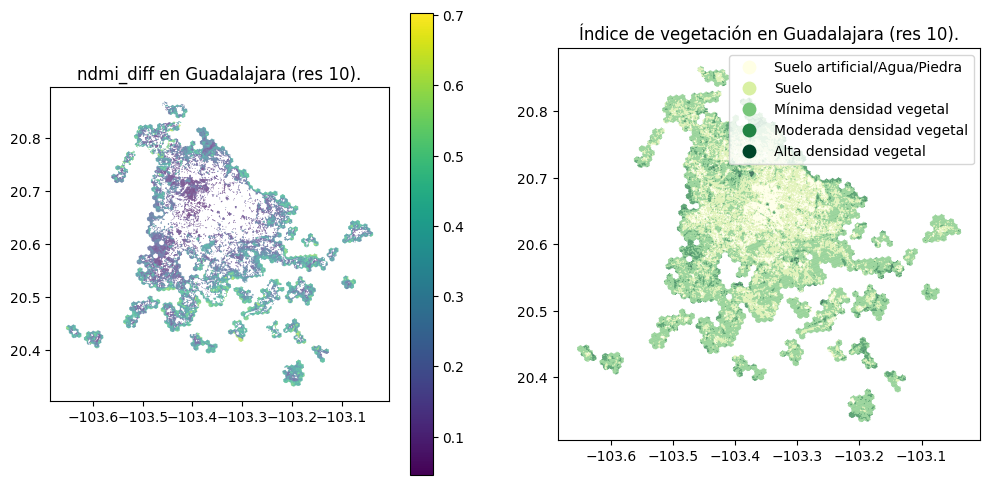

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ndvi_ndmi_res10.plot('ndmi_diff', 'viridis', ax=ax[0], legend=True)
ndvi_res10.plot('ndvi_median_rango', 'YlGn', ax=ax[1], legend=True)

ax[0].set_title('ndmi_diff en {} (res 10).'.format(city))
ax[1].set_title('Índice de vegetación en {} (res {}).'.format(city,res))

# Guardar gráficos
plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmidiff_{}.svg".format(city.lower(),city.lower()))